# GPU Sanity Check

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec  6 17:15:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#Importing Libraries & Connecting to Drive

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import imghdr

import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras
from keras.utils import np_utils
from keras.applications import mobilenet_v2
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Activation
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.applications.mobilenet_v2 import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir='/content/drive/MyDrive/final_split'

In [6]:

#In the dir folder images are split between train, val and test 
for image_class in os.listdir(dir):
  print(image_class)

train
val
test


# Quick EDA 

I am checking class distribution on the train data

In [ ]:
train_dir=dir+'/train'

class_count={}
for image_class in os.listdir(train_dir):
  class_count[image_class]=len(os.listdir(train_dir+'/'+image_class))
class_df=pd.DataFrame.from_dict(class_count,orient='index').reset_index().rename(columns={'index':'Artist',0:'Train'})

In [ ]:
val_dir=dir+'/val'

class_count_val={}
for image_class in os.listdir(val_dir):
  class_count_val[image_class]=len(os.listdir(val_dir+'/'+image_class))


In [ ]:
test_dir=dir+'/test'

class_count_test={}
for image_class in os.listdir(test_dir):
  class_count_test[image_class]=len(os.listdir(test_dir+'/'+image_class))


In [ ]:
class_count

{'Alfred_Sisley': 181,
 'Albrecht_Dürer': 229,
 'Edgar_Degas': 491,
 'Francisco_Goya': 203,
 'Paul_Gauguin': 217,
 'Marc_Chagall': 167,
 'Pierre-Auguste_Renoir': 235,
 'Pablo_Picasso': 321,
 'Vincent_van_Gogh': 613,
 'Titian': 178,
 'Rembrandt': 183}

In [ ]:
class_count_test

{'Alfred_Sisley': 27,
 'Albrecht_Dürer': 34,
 'Edgar_Degas': 71,
 'Francisco_Goya': 30,
 'Paul_Gauguin': 32,
 'Marc_Chagall': 25,
 'Pierre-Auguste_Renoir': 34,
 'Pablo_Picasso': 47,
 'Vincent_van_Gogh': 89,
 'Titian': 26,
 'Rembrandt': 27}

In [ ]:
class_count_val

{'Alfred_Sisley': 51,
 'Albrecht_Dürer': 65,
 'Edgar_Degas': 140,
 'Francisco_Goya': 58,
 'Paul_Gauguin': 62,
 'Marc_Chagall': 47,
 'Pierre-Auguste_Renoir': 67,
 'Pablo_Picasso': 91,
 'Vincent_van_Gogh': 175,
 'Titian': 51,
 'Rembrandt': 52}

In [ ]:
df=pd.DataFrame()

In [ ]:
df.index=class_count.keys()
df.index=df.index.map(lambda x: x.replace('_',' '))

In [ ]:
df['Train']=class_count.values()
df['Val']=class_count_val.values()
df['Test']=class_count_test.values()

In [ ]:
df.sort_values('Train',inplace=True)

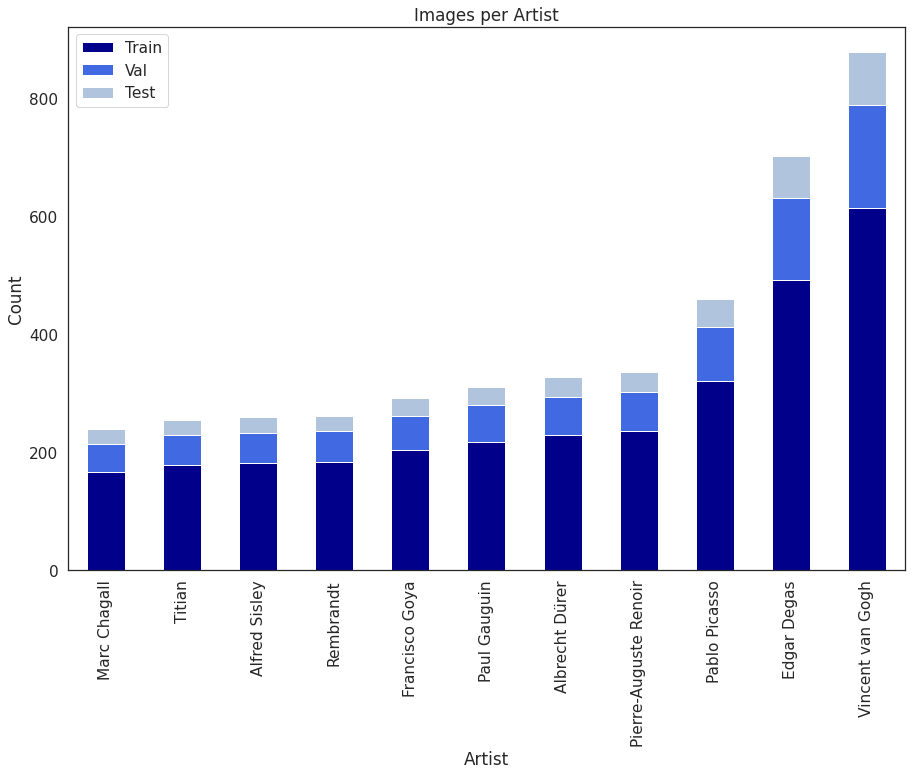

In [ ]:
#sns.figsize
#
figsize=(100,20)
sns.set(style='white',font_scale=1.4)
#plt.figure(figsize=(20,20)
#sns.set(style='white')
df.plot(kind='bar', stacked=True, color=['darkblue','royalblue','lightsteelblue'],figsize=(15,10))
plt.xlabel('Artist')
plt.ylabel('Count')
plt.title('Images per Artist')
plt.show()
# title of plot

In [ ]:
class_df

Artist  Count
8        Vincent_van_Gogh    613
4             Edgar_Degas    491
0           Pablo_Picasso    321
1   Pierre-Auguste_Renoir    235
3         Albrecht_Dürer    229
6            Paul_Gauguin    217
5          Francisco_Goya    203
10              Rembrandt    183
2           Alfred_Sisley    181
9                  Titian    178
7            Marc_Chagall    167

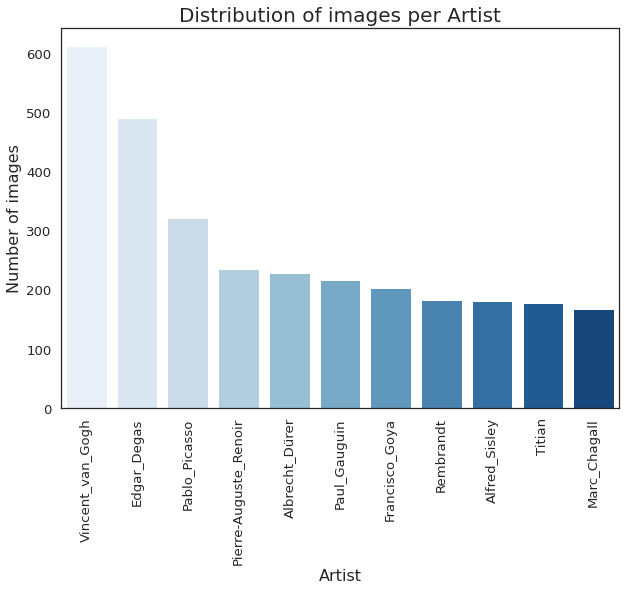

In [ ]:
sns.set(style='white',font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(data=class_df,x='Artist',y='Count',palette='Blues')
ax.set_xlabel('Artist',size=16)
ax.set_ylabel('Number of images',size=16)
ax.set_title('Distribution of images per Artist',size=20)
ax.tick_params(axis='x', rotation=90)

[Text(0.5, 0, 'Photos per artist')]

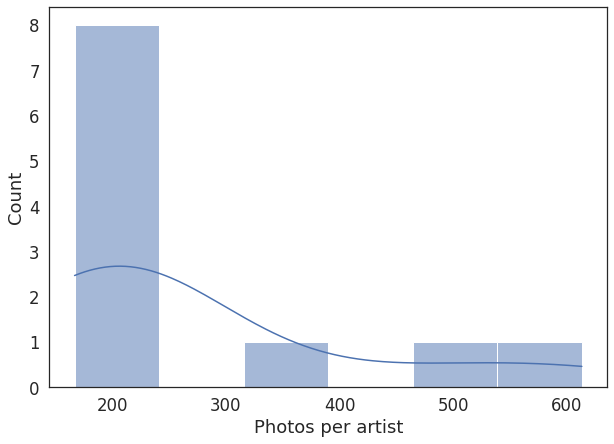

In [ ]:
sns.set(style='white',font_scale=1.5)
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1=sns.histplot(data=class_df,x='Count',kde=True)
ax1.set(xlabel='Photos per artist')

Looks like classes are imbalanced: I think it would make sense to report on F1 instead of accuracy.
I will start with a baseline model and then test the effect of adjusting class weights and image augmentation on F1, Precision and Recall. 

# Baseline Model with Transfer Learning

## Data Splitting

In [7]:
train_dir=dir+'/train'
val_dir=dir+'/val'
test_dir=dir+'/test'

In [8]:
pixel_scale = ImageDataGenerator(preprocessing_function = preprocess_input)

In [9]:
#class names to be able to reference 
class_names = sorted([image_class for image_class in os.listdir(train_dir)])

In [ ]:
train=pixel_scale.flow_from_directory(
            train_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 3018 images belonging to 11 classes.


In [ ]:
val = pixel_scale.flow_from_directory(
            val_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 859 images belonging to 11 classes.


In [ ]:
test = pixel_scale.flow_from_directory(
            test_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 442 images belonging to 11 classes.


## Baseline with MobileNet V2

In [ ]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    
# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(11, activation='softmax')(x) # should match # of classes predicted
# define formal model object to train and compile it as usual
baseline_MNV2 = Model(inputs=base_model.input, outputs=predictions)
baseline_MNV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy','AUC','Precision','Recall'])

In [ ]:
baseline_training= baseline_MNV2.fit(train, epochs=20, validation_data=val)

Epoch 1/20
95/95 [==============================] - 80s 786ms/step - loss: 2.8991 - Accuracy: 0.4659 - auc: 0.8150 - precision: 0.5050 - recall: 0.4195 - val_loss: 1.1981 - val_Accuracy: 0.6612 - val_auc: 0.9316 - val_precision: 0.7030 - val_recall: 0.6007
Epoch 2/20
95/95 [==============================] - 73s 771ms/step - loss: 0.4375 - Accuracy: 0.8638 - auc: 0.9877 - precision: 0.8919 - recall: 0.8340 - val_loss: 1.0886 - val_Accuracy: 0.7206 - val_auc: 0.9411 - val_precision: 0.7567 - val_recall: 0.6950
Epoch 3/20
95/95 [==============================] - 73s 768ms/step - loss: 0.1102 - Accuracy: 0.9702 - auc: 0.9995 - precision: 0.9781 - recall: 0.9622 - val_loss: 1.0140 - val_Accuracy: 0.7474 - val_auc: 0.9498 - val_precision: 0.7824 - val_recall: 0.7241
Epoch 4/20
95/95 [==============================] - 72s 761ms/step - loss: 0.0254 - Accuracy: 0.9973 - auc: 1.0000 - precision: 0.9973 - recall: 0.9967 - val_loss: 1.0638 - val_Accuracy: 0.7555 - val_auc: 0.9445 - val_precision: 

In [350]:
def plot_performance(hist):
  
  fig = plt.figure()
  plt.plot(hist.history['loss'], color='teal', label='loss')
  plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
  plt.xticks(size=14)
  plt.yticks(size=14)
  plt.xlabel('Epoch',fontsize=14)
  plt.ylabel('Loss',fontsize=14)
  fig.suptitle('Loss', fontsize=18)
  plt.legend(loc="upper left")
  plt.show()


  fig = plt.figure()
  plt.plot(hist.history['recall'], color='teal', label='recall')
  plt.plot(hist.history['val_recall'], color='orange', label='val_recall')
  plt.xticks(size=14)
  plt.yticks(size=14)
  plt.ylim(bottom=0,top=1.1)
  plt.xlabel('Epoch',fontsize=14)
  plt.ylabel('Recall',fontsize=14)
  fig.suptitle('Recall', fontsize=18)
  plt.legend(loc="upper left")
  plt.show()

  fig = plt.figure()
  plt.plot(hist.history['precision'], color='teal', label='precision')
  plt.plot(hist.history['val_precision'], color='orange', label='val_precision')
  plt.xticks(size=14)
  plt.ylim(bottom=0,top=1.1)
  plt.yticks(size=14)
  plt.xlabel('Epoch',fontsize=14)
  plt.ylabel('Precision',fontsize=14)
  fig.suptitle('Precision', fontsize=18)
  plt.legend(loc="upper left")
  plt.show()


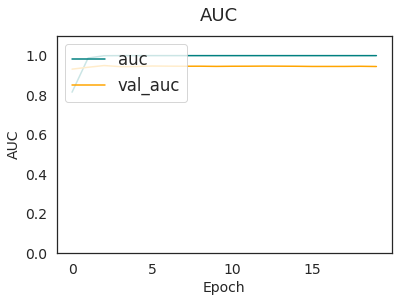

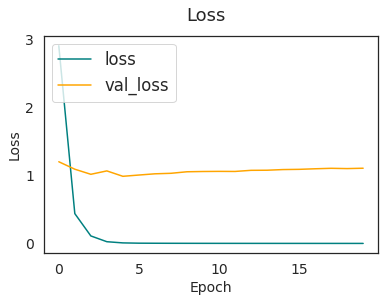

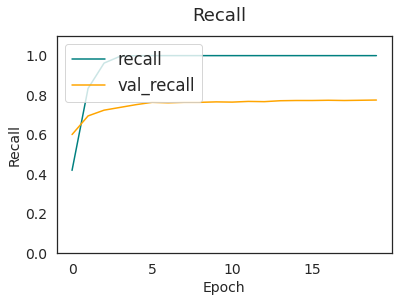

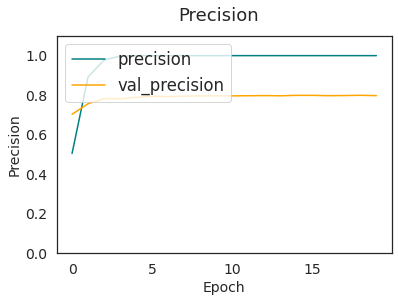

In [ ]:
plot_performance(baseline_training)

In [ ]:
#confusion matrix
test_pred = baseline_MNV2.predict(test)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

14/14 [==============================] - 8s 606ms/step


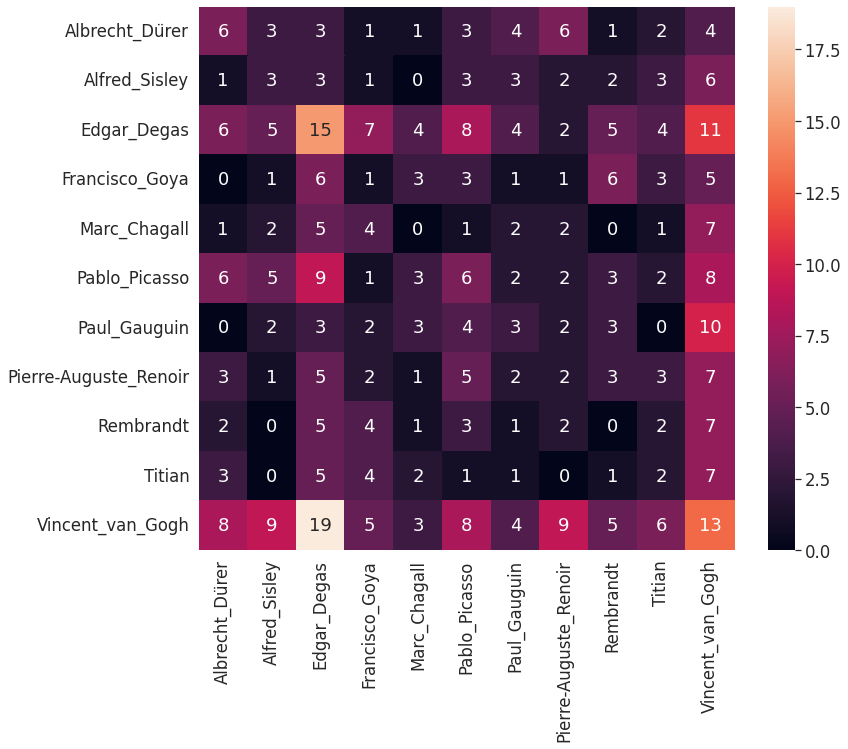

# Baseline Model + class weights adjustment

As seen below, in the beginning of the notebook it was obvious that the classes where imbalanced with available photos by classes ranging from 200 to 600

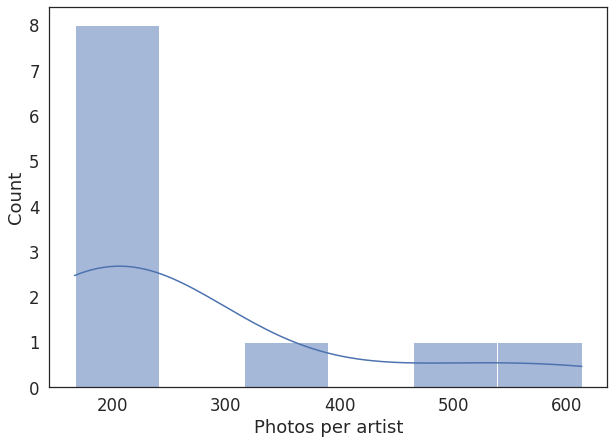

In [ ]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    
# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(11, activation='softmax')(x) # should match # of classes predicted
# define formal model object to train and compile it as usual
baseline_CW = Model(inputs=base_model.input, outputs=predictions)
baseline_CW.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy','AUC','Precision','Recall'])

In [228]:
from sklearn.utils import class_weight

In [232]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train.classes), class_weights))
class_weights

{0: 1.1980944819372767,
 1: 1.5158211953792065,
 2: 0.558785410109239,
 3: 1.3515450067174206,
 4: 1.642896026129559,
 5: 0.8547153780798641,
 6: 1.2643485546711353,
 7: 1.167504835589942,
 8: 1.4992548435171387,
 9: 1.5413687436159347,
 10: 0.4475752632359484}

In [ ]:
 baseline_cw= baseline_CW.fit(train, epochs=20, validation_data=val,class_weight=class_weights)

Epoch 1/20
95/95 [==============================] - 78s 790ms/step - loss: 2.4305 - Accuracy: 0.3161 - auc: 0.7493 - precision: 0.4862 - recall: 0.1925 - val_loss: 1.5781 - val_Accuracy: 0.4482 - val_auc: 0.8687 - val_precision: 0.6982 - val_recall: 0.3097
Epoch 2/20
95/95 [==============================] - 73s 769ms/step - loss: 0.9874 - Accuracy: 0.6322 - auc: 0.9336 - precision: 0.7629 - recall: 0.5331 - val_loss: 1.2095 - val_Accuracy: 0.6205 - val_auc: 0.9239 - val_precision: 0.7476 - val_recall: 0.5343
Epoch 3/20
95/95 [==============================] - 73s 766ms/step - loss: 0.4333 - Accuracy: 0.8343 - auc: 0.9840 - precision: 0.8907 - recall: 0.7883 - val_loss: 1.4227 - val_Accuracy: 0.6158 - val_auc: 0.9172 - val_precision: 0.6684 - val_recall: 0.5821
Epoch 4/20
95/95 [==============================] - 73s 767ms/step - loss: 0.2576 - Accuracy: 0.9019 - auc: 0.9931 - precision: 0.9293 - recall: 0.8887 - val_loss: 1.2370 - val_Accuracy: 0.6380 - val_auc: 0.9352 - val_precision: 

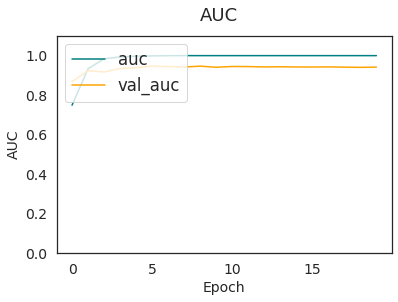

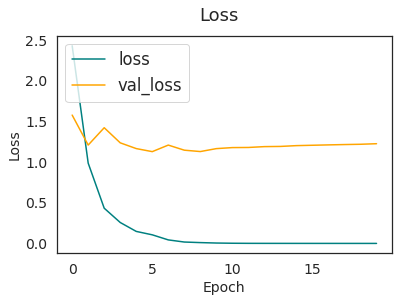

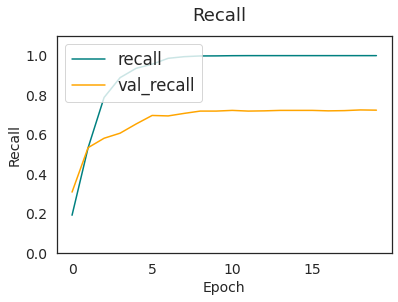

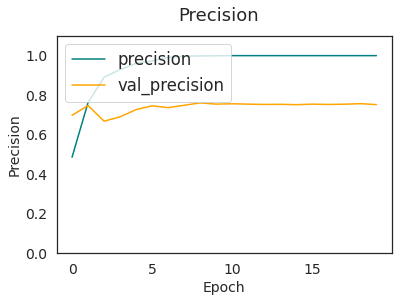

In [ ]:
plot_performance(baseline_cw)

14/14 [==============================] - 9s 625ms/step


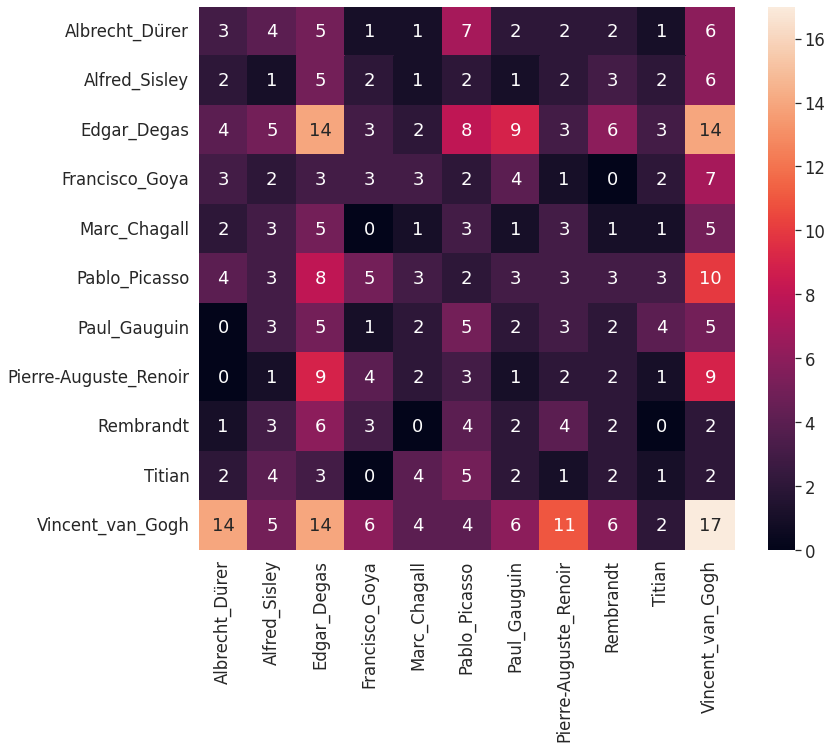

In [ ]:
#confusion matrix
test_pred = baseline_CW.predict(test)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

# Image Augmentation

In [10]:
augmentation = ImageDataGenerator( preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                    horizontal_flip = True,
                                    vertical_flip = True)
                                    # brightness_range=(0.1, 0.9),
                                    # fill_mode='nearest')

In [11]:
train_augmented=augmentation.flow_from_directory(
                                                  train_dir,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  classes = class_names,
                                                  seed = 123,
                                                  batch_size=32,
                                                  shuffle=True)

Found 3018 images belonging to 11 classes.


In [309]:
img,labels=next(train_vgg_aug)

In [310]:
def plotImages(images_arr):
  fig,axes=plt.subplots(2,5,figsize=(20,10))
  axes=axes.flatten()
  i=0
  for img,ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.set_title(class_names[np.argmax(labels[i])])
    #ax.axis('off')
    i+=1
  plt.tight_layout()
  plt.show()

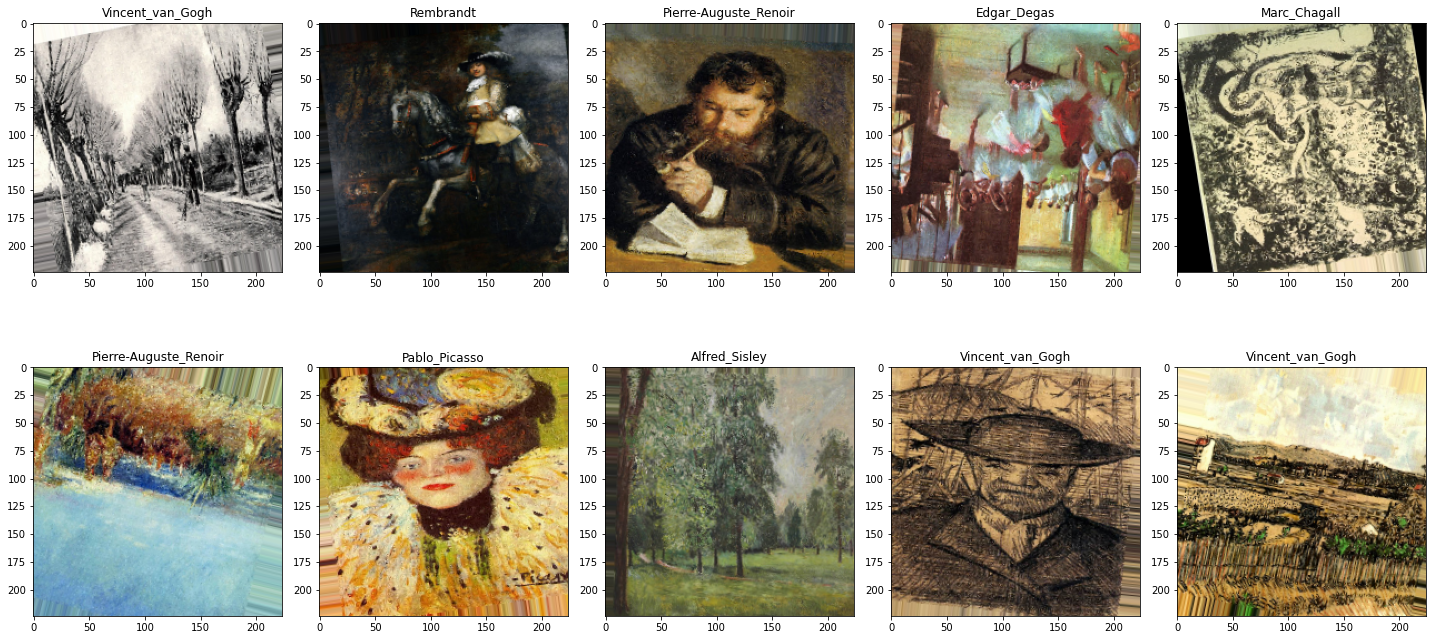

In [311]:
plotImages(img)

In [ ]:
img = train_augmented.next()

0


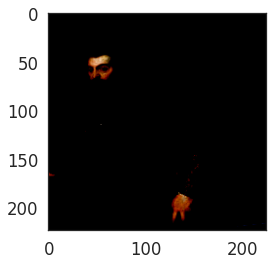

1


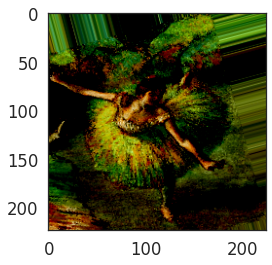

2


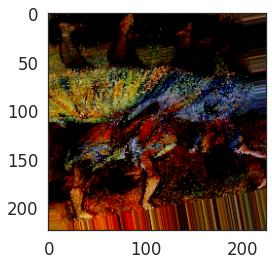

3


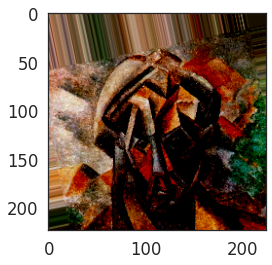

4


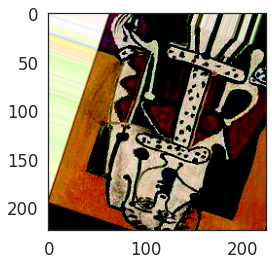

5


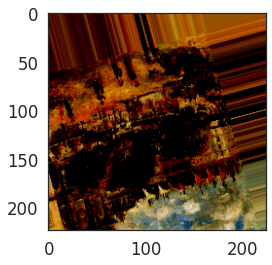

6


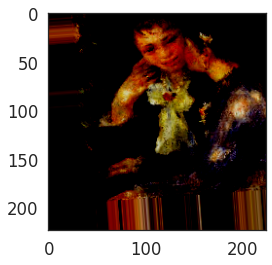

7


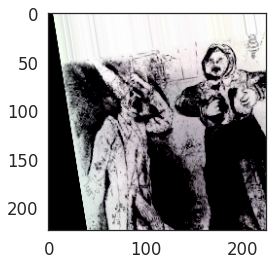

8


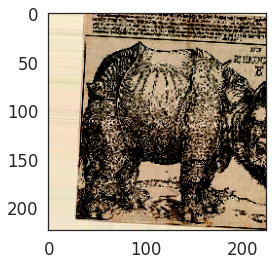

9


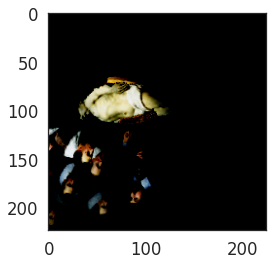

10


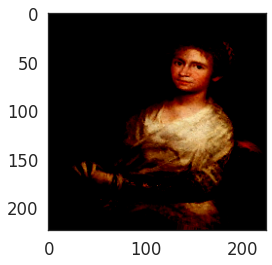

11


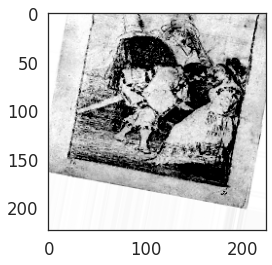

12


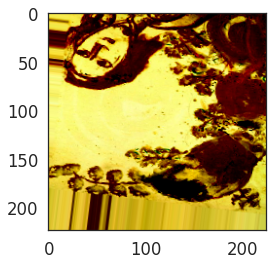

13


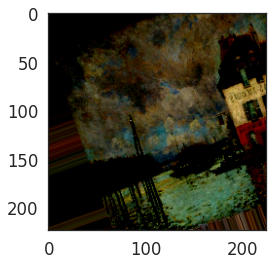

14


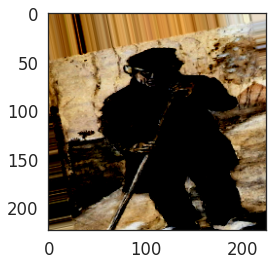

15


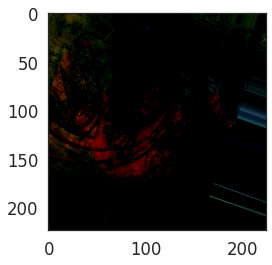

16


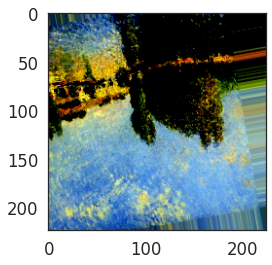

17


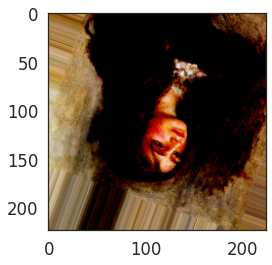

18


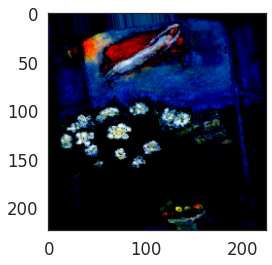

19


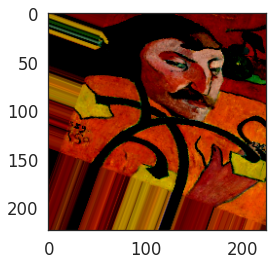

20


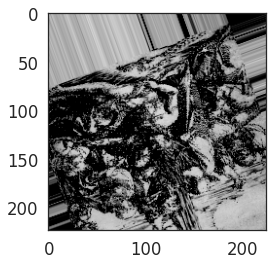

21


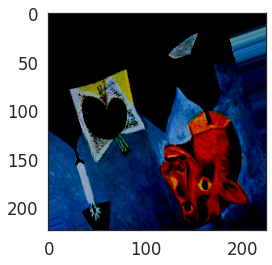

22


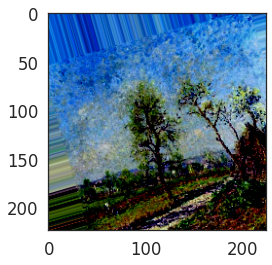

23


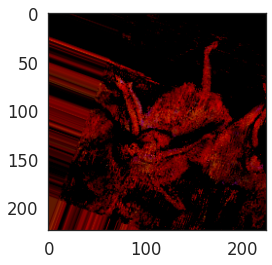

24


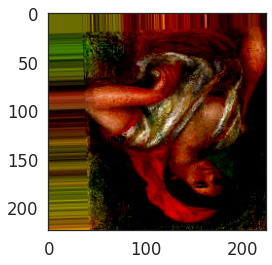

25


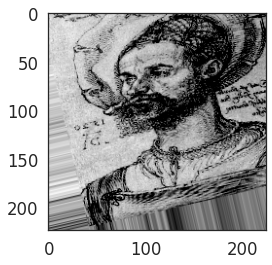

26


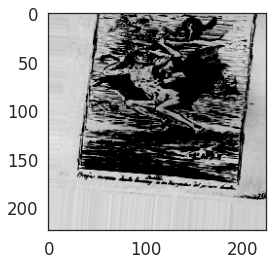

27


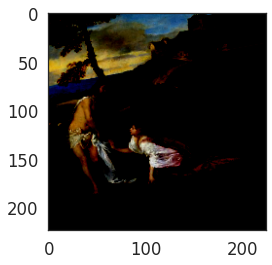

28


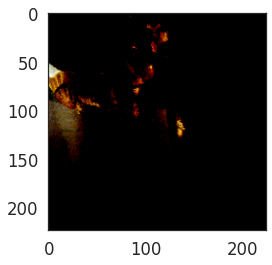

29


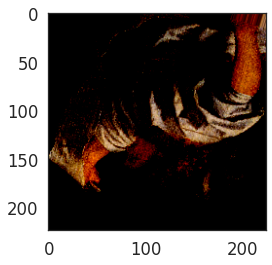

30


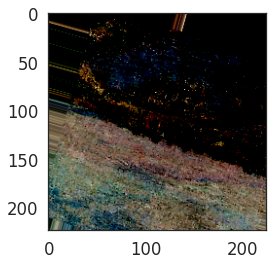

31


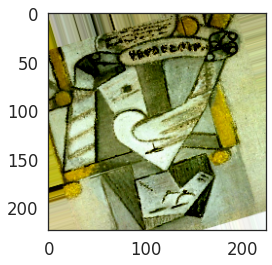

In [ ]:
from matplotlib import pyplot as PLT
for i in range(len(img[0])):
  print(i)
  PLT.imshow(img[0][i])
  PLT.show()
# img[0][0].shape

In [ ]:
img[1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
baseline_augmented= baseline_MNV2.fit(train_augmented, epochs=20, validation_data=val,class_weight=class_weights)

Epoch 1/20
95/95 [==============================] - 106s 1s/step - loss: 3.1897 - Accuracy: 0.3241 - auc: 0.7348 - precision: 0.3922 - recall: 0.2376 - val_loss: 2.1309 - val_Accuracy: 0.4773 - val_auc: 0.8071 - val_precision: 0.6062 - val_recall: 0.3423
Epoch 2/20
95/95 [==============================] - 102s 1s/step - loss: 1.5593 - Accuracy: 0.5070 - auc: 0.8667 - precision: 0.6016 - recall: 0.4109 - val_loss: 1.6322 - val_Accuracy: 0.5448 - val_auc: 0.8789 - val_precision: 0.6437 - val_recall: 0.4354
Epoch 3/20
95/95 [==============================] - 101s 1s/step - loss: 1.2946 - Accuracy: 0.5822 - auc: 0.8975 - precision: 0.6633 - recall: 0.5020 - val_loss: 1.4845 - val_Accuracy: 0.5704 - val_auc: 0.9019 - val_precision: 0.6368 - val_recall: 0.5041
Epoch 4/20
95/95 [==============================] - 101s 1s/step - loss: 1.2084 - Accuracy: 0.5968 - auc: 0.9090 - precision: 0.6646 - recall: 0.5345 - val_loss: 1.3476 - val_Accuracy: 0.5972 - val_auc: 0.9136 - val_precision: 0.6701 -

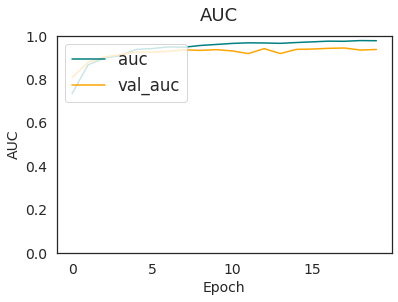

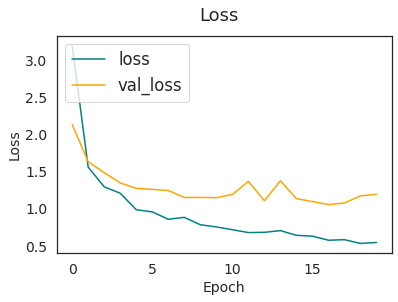

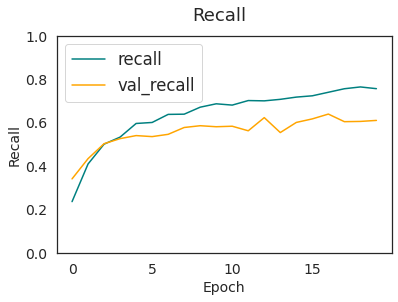

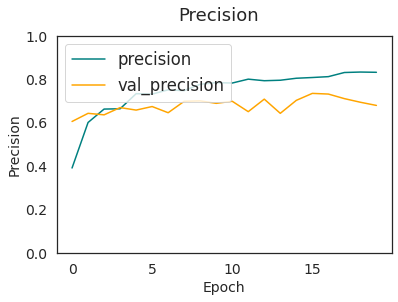

In [ ]:
plot_performance(baseline_augmented)

In [143]:
#confusion matrix
test_pred = baseline_CW.predict(test)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

NameError: ignored

# Testing out other Models for Transfer Learning 

##ResNet50

### Baseline

In [210]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [211]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [214]:
resnet_scale=ImageDataGenerator(preprocessing_function = preprocess_input)

In [215]:
train_res=resnet_scale.flow_from_directory(
            train_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 3018 images belonging to 11 classes.


In [267]:
val_res=resnet_scale.flow_from_directory(
            val_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 859 images belonging to 11 classes.


In [217]:
test_res=resnet_scale.flow_from_directory(
            test_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True,
            )

Found 442 images belonging to 11 classes.


In [96]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [218]:
# Load pre-trained model
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = True
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(11, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 [==============================] - 1s 0us/step


In [219]:
f1 = tfa.metrics.F1Score(num_classes=11, average=None)

NameError: ignored

In [220]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy','Precision','Recall'])

In [221]:
es = EarlyStopping(monitor='val_recall', patience=3,mode='max')

In [222]:
resnet_50= model.fit(train_res, epochs=20, validation_data=val_res,callbacks=es)

Epoch 1/20
95/95 [==============================] - 84s 790ms/step - loss: 1.6119 - accuracy: 0.5331 - precision: 0.8959 - recall: 0.1455 - val_loss: 2.7131 - val_accuracy: 0.0594 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
95/95 [==============================] - 72s 764ms/step - loss: 1.0400 - accuracy: 0.8814 - precision: 0.9977 - recall: 0.2879 - val_loss: 2.5483 - val_accuracy: 0.0594 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
81/95 [========================>.....] - ETA: 8s - loss: 0.8643 - accuracy: 0.9646 - precision: 1.0000 - recall: 0.3595

KeyboardInterrupt: ignored

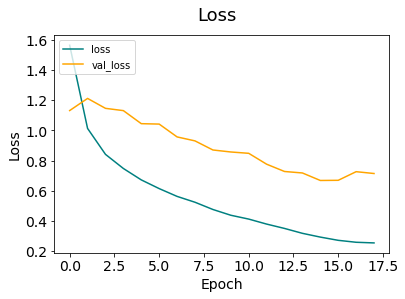

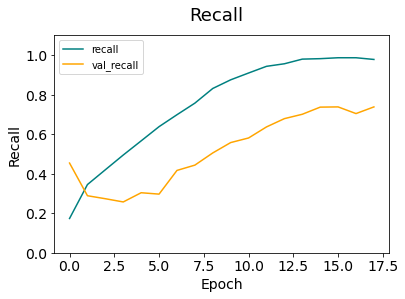

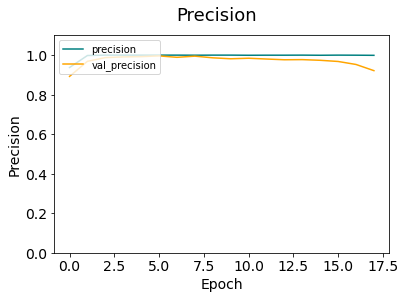

In [100]:
plot_performance(resnet_50)

14/14 [==============================] - 100s 8s/step


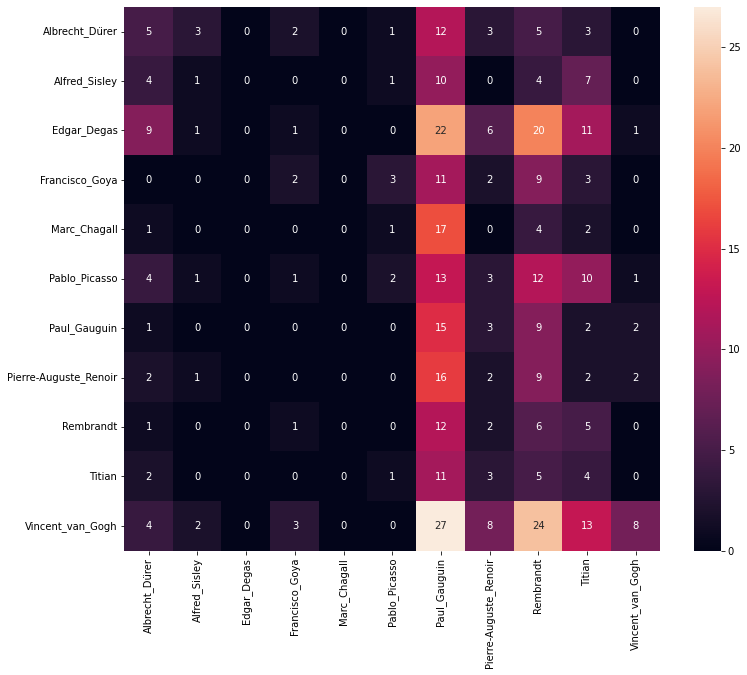

In [106]:
#confusion matrix
test_pred = model.predict(test_res)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test_res.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

### Class Weights

In [227]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_res.classes),
                                        y = train_res.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_res.classes), class_weights))
class_weights

NameError: ignored

In [ ]:
resnet_cw= model.fit(train_res, epochs=20, validation_data=val_res,class_weight=class_weights)

Epoch 1/20
95/95 [==============================] - 78s 758ms/step - loss: 1.5440 - accuracy: 0.4549 - f1_score: 0.4808 - precision: 0.8439 - recall: 0.1541 - val_loss: 1.3725 - val_accuracy: 0.5471 - val_f1_score: 0.5697 - val_precision: 0.7671 - val_recall: 0.4179
Epoch 2/20
95/95 [==============================] - 70s 735ms/step - loss: 0.9724 - accuracy: 0.7333 - f1_score: 0.7651 - precision: 0.9990 - recall: 0.3403 - val_loss: 1.3333 - val_accuracy: 0.6449 - val_f1_score: 0.6895 - val_precision: 0.9590 - val_recall: 0.3271
Epoch 3/20
95/95 [==============================] - 70s 738ms/step - loss: 0.8053 - accuracy: 0.8125 - f1_score: 0.8440 - precision: 0.9992 - recall: 0.4231 - val_loss: 1.3141 - val_accuracy: 0.6973 - val_f1_score: 0.7281 - val_precision: 0.9811 - val_recall: 0.3027
Epoch 4/20
95/95 [==============================] - 70s 736ms/step - loss: 0.7164 - accuracy: 0.8446 - f1_score: 0.8736 - precision: 1.0000 - recall: 0.4967 - val_loss: 1.2657 - val_accuracy: 0.7183 

14/14 [==============================] - 9s 595ms/step


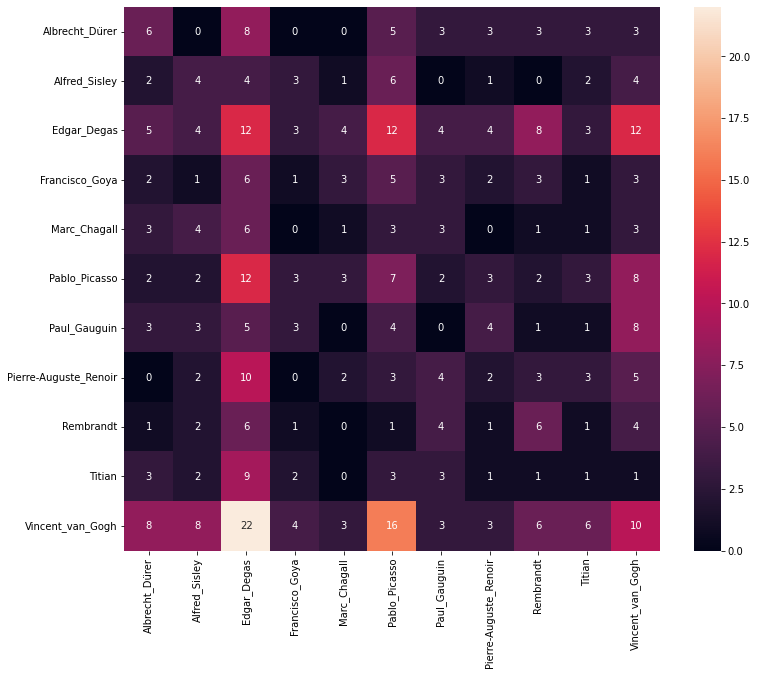

In [141]:
#confusion matrix
test_pred = model.predict(test_res)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test_res.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

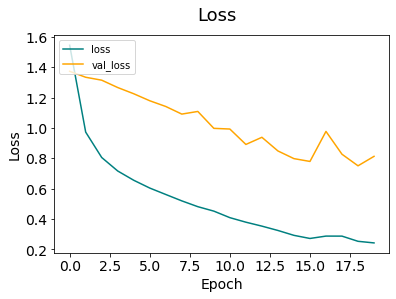

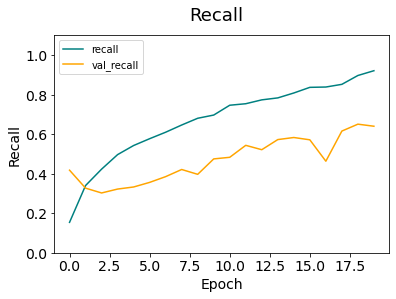

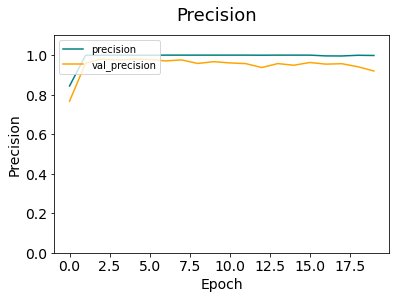

In [142]:
plot_performance(resnet_cw)

In [ ]:
#augmented

### Augmentation

In [232]:
# Load pre-trained model
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = True
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(11, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)


In [233]:
augmentation = ImageDataGenerator( preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                    horizontal_flip = True,
                                    vertical_flip = True)
                                    # brightness_range=(0.1, 0.9),
                                    # fill_mode='nearest')

In [234]:
train_res_aug=augmentation.flow_from_directory(
                                                  train_dir,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  classes = class_names,
                                                  seed = 123,
                                                  batch_size=32,
                                                  shuffle=True)

Found 3018 images belonging to 11 classes.


In [235]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy',f1,'Precision','Recall'])

In [236]:
resnet_augmented= model.fit(train_res_aug, epochs=10, validation_data=val_res,class_weight=class_weights)

Epoch 1/10
95/95 [==============================] - 105s 1s/step - loss: 1.5988 - accuracy: 0.4728 - f1_score: 0.5412 - precision: 0.8707 - recall: 0.1272 - val_loss: 1.4236 - val_accuracy: 0.5891 - val_f1_score: 0.6073 - val_precision: 0.7287 - val_recall: 0.4470
Epoch 2/10
95/95 [==============================] - 97s 1s/step - loss: 1.1745 - accuracy: 0.6958 - f1_score: 0.7049 - precision: 0.9273 - recall: 0.2409 - val_loss: 1.1846 - val_accuracy: 0.6880 - val_f1_score: 0.6884 - val_precision: 0.9300 - val_recall: 0.4331
Epoch 3/10
95/95 [==============================] - 97s 1s/step - loss: 1.0213 - accuracy: 0.7757 - f1_score: 0.7801 - precision: 0.9458 - recall: 0.3125 - val_loss: 1.0237 - val_accuracy: 0.7858 - val_f1_score: 0.7846 - val_precision: 0.9715 - val_recall: 0.4761
Epoch 4/10
95/95 [==============================] - 97s 1s/step - loss: 0.9063 - accuracy: 0.8274 - f1_score: 0.8325 - precision: 0.9639 - recall: 0.3890 - val_loss: 1.2448 - val_accuracy: 0.6903 - val_f1_sc

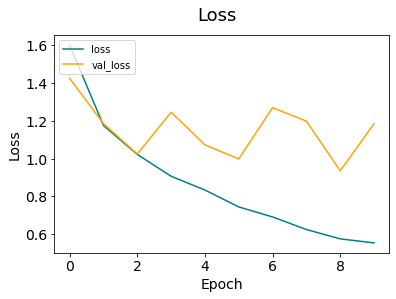

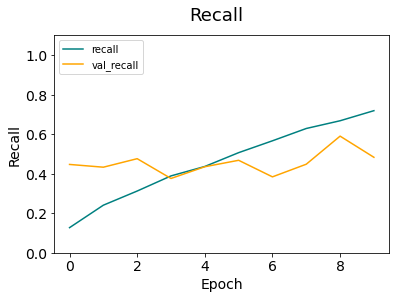

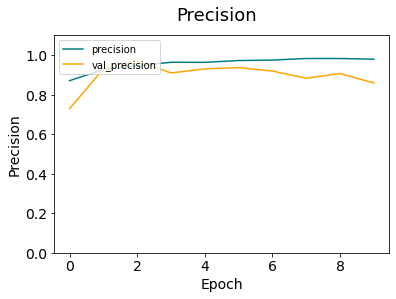

In [237]:
plot_performance(resnet_augmented)

14/14 [==============================] - 9s 595ms/step


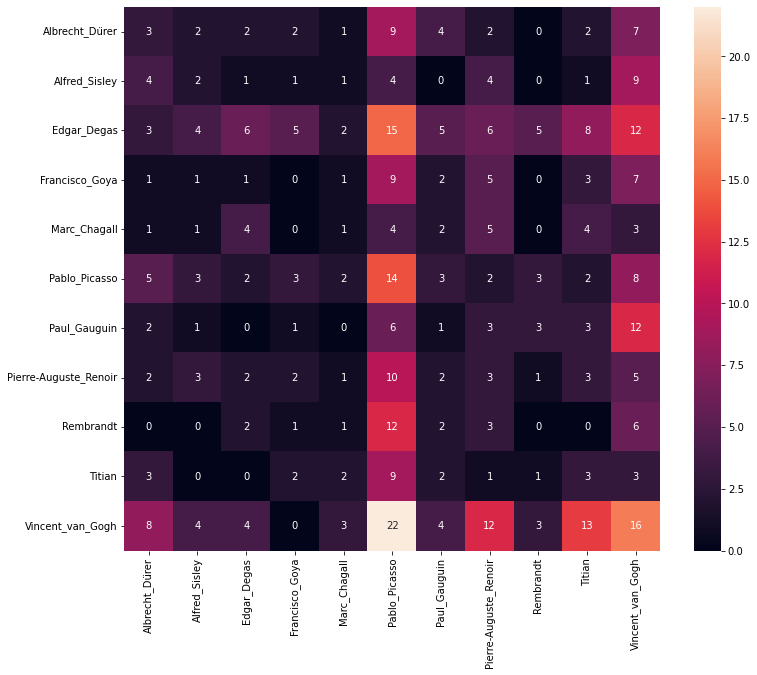

In [238]:
#confusion matrix
test_pred = model.predict(test_res)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test_res.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

##VGG16

### Baseline

In [223]:
from keras.applications.vgg16 import preprocess_input

In [194]:
vgg_scale=ImageDataGenerator(rescale=1/255)

In [195]:
train_vgg=vgg_scale.flow_from_directory(
            train_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 3018 images belonging to 11 classes.


In [318]:
val_vgg=vgg_scale.flow_from_directory(
            val_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 859 images belonging to 11 classes.


In [319]:

test_vgg=vgg_scale.flow_from_directory(
            test_dir,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = class_names,
            seed = 123,
            batch_size=32,
            shuffle=True)

Found 442 images belonging to 11 classes.


In [202]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(120, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.2)(x)
#x = Dense(50, activation='elu')(x) # number of layers and units are hyperparameters, as usual
predictions = Dense(11, activation='softmax')(x) # should match # of classes predicted


# define formal model object to train and compile it as usual
model5 = Model(inputs=base_model.input, outputs=predictions)
model5.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['Recall','Precision'])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.876521 to fit



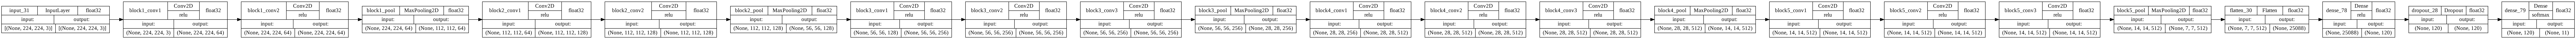

In [224]:
tf.keras.utils.plot_model(
    model5,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=400,
    layer_range=None,
    show_layer_activations=True,
)

In [204]:
es=EarlyStopping(monitor='val_recall',patience=3,mode='max')

In [205]:
vgg_base= model5.fit(train_vgg, epochs=20,callbacks=es,validation_data=val_vgg)

Epoch 1/20
95/95 [==============================] - 76s 794ms/step - loss: 1.8788 - recall: 0.1637 - precision: 0.6358 - val_loss: 1.4149 - val_recall: 0.2247 - val_precision: 0.8935
Epoch 2/20
95/95 [==============================] - 74s 785ms/step - loss: 1.1843 - recall: 0.4245 - precision: 0.7878 - val_loss: 1.0219 - val_recall: 0.5099 - val_precision: 0.8051
Epoch 3/20
95/95 [==============================] - 74s 783ms/step - loss: 0.8475 - recall: 0.6001 - precision: 0.8478 - val_loss: 1.0141 - val_recall: 0.5146 - val_precision: 0.8355
Epoch 4/20
95/95 [==============================] - 74s 784ms/step - loss: 0.6522 - recall: 0.6786 - precision: 0.8862 - val_loss: 0.9026 - val_recall: 0.6170 - val_precision: 0.8030
Epoch 5/20
95/95 [==============================] - 74s 780ms/step - loss: 0.5163 - recall: 0.7445 - precision: 0.9042 - val_loss: 0.9075 - val_recall: 0.6542 - val_precision: 0.7949
Epoch 6/20
95/95 [==============================] - 74s 781ms/step - loss: 0.4165 - r

In [206]:
model5.save('vgg_16_base_2.pt')

In [207]:
m = keras.models.load_model('vgg_16_base_2.pt')

14/14 [==============================] - 9s 599ms/step


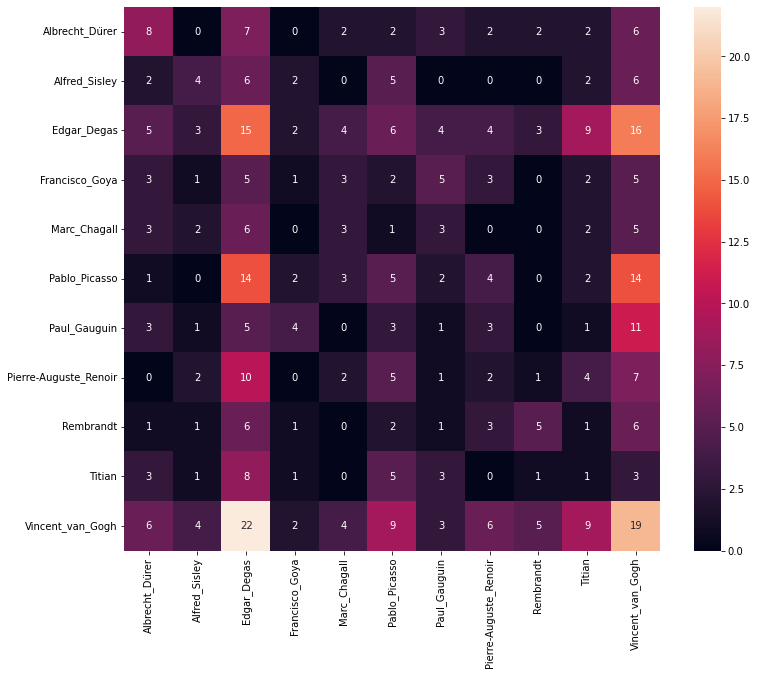

In [208]:
#confusion matrix
test_pred = m.predict(test_vgg)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test_vgg.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

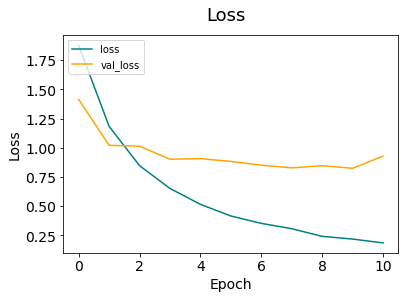

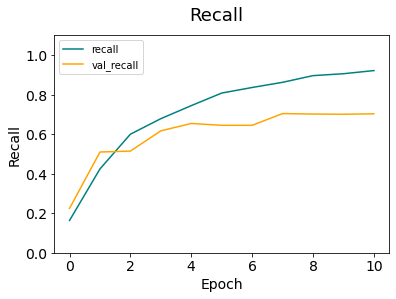

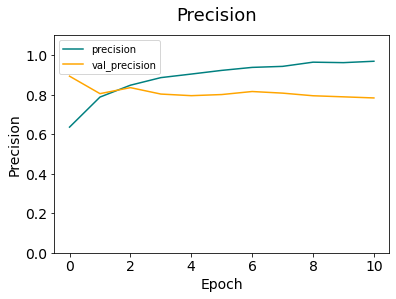

In [209]:
plot_performance(vgg_base)

14/14 [==============================] - 9s 619ms/step


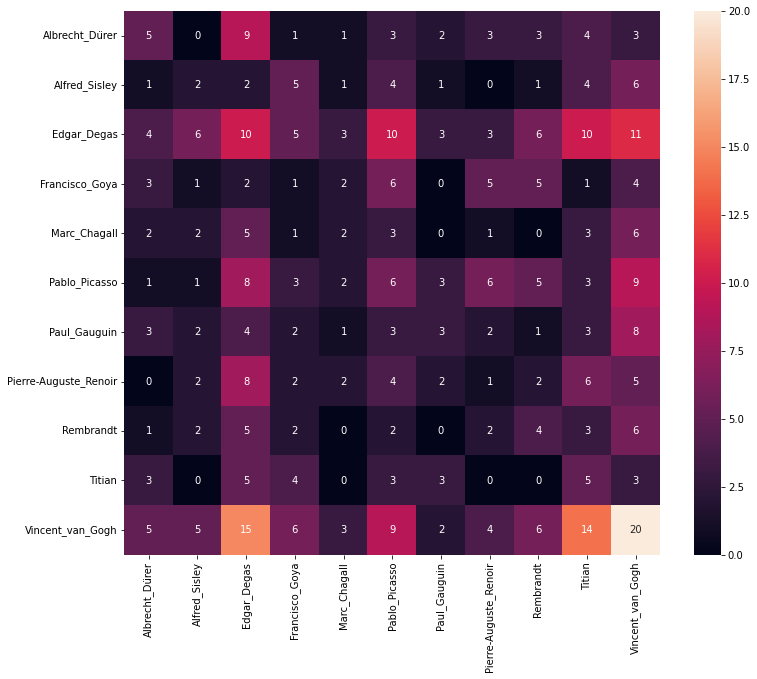

In [198]:
#confusion matrix
test_pred = model5.predict(test_vgg)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test_vgg.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

### Class Weights

In [234]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(120, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.2)(x)
#x = Dense(50, activation='elu')(x) # number of layers and units are hyperparameters, as usual
predictions = Dense(11, activation='softmax')(x) # should match # of classes predicted


# define formal model object to train and compile it as usual
model5 = Model(inputs=base_model.input, outputs=predictions)
model5.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['Recall','Precision'])
es=EarlyStopping(monitor='val_recall',patience=4,mode='max')

In [235]:
vgg_cw= model5.fit(train_vgg, epochs=20, validation_data=val_vgg,class_weight=class_weights)

Epoch 1/20
95/95 [==============================] - 75s 779ms/step - loss: 2.0090 - recall: 0.1312 - precision: 0.5266 - val_loss: 1.4684 - val_recall: 0.2503 - val_precision: 0.7818
Epoch 2/20
95/95 [==============================] - 73s 770ms/step - loss: 1.1755 - recall: 0.3688 - precision: 0.7546 - val_loss: 1.1486 - val_recall: 0.4470 - val_precision: 0.7665
Epoch 3/20
95/95 [==============================] - 73s 769ms/step - loss: 0.9090 - recall: 0.5080 - precision: 0.8094 - val_loss: 1.0311 - val_recall: 0.4703 - val_precision: 0.8330
Epoch 4/20
95/95 [==============================] - 73s 766ms/step - loss: 0.6412 - recall: 0.6388 - precision: 0.8569 - val_loss: 0.9743 - val_recall: 0.5576 - val_precision: 0.7891
Epoch 5/20
95/95 [==============================] - 73s 768ms/step - loss: 0.5133 - recall: 0.7207 - precision: 0.8881 - val_loss: 0.8999 - val_recall: 0.6217 - val_precision: 0.7818
Epoch 6/20
95/95 [==============================] - 73s 768ms/step - loss: 0.3980 - r

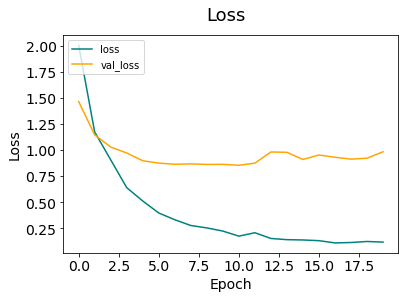

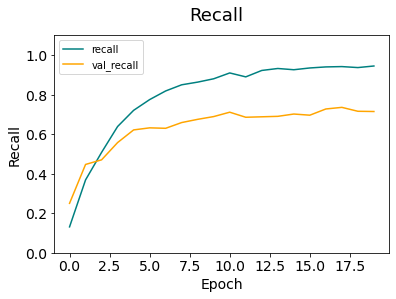

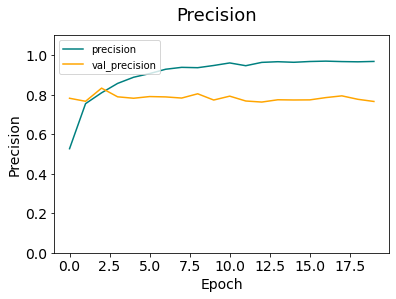

In [236]:
plot_performance(vgg_cw)

In [237]:
model5.save('vgg_16_cw.pt')
#m= keras.models.load_model('vgg_16_cw.pt')

In [238]:
m= keras.models.load_model('vgg_16_cw.pt')

14/14 [==============================] - 9s 618ms/step


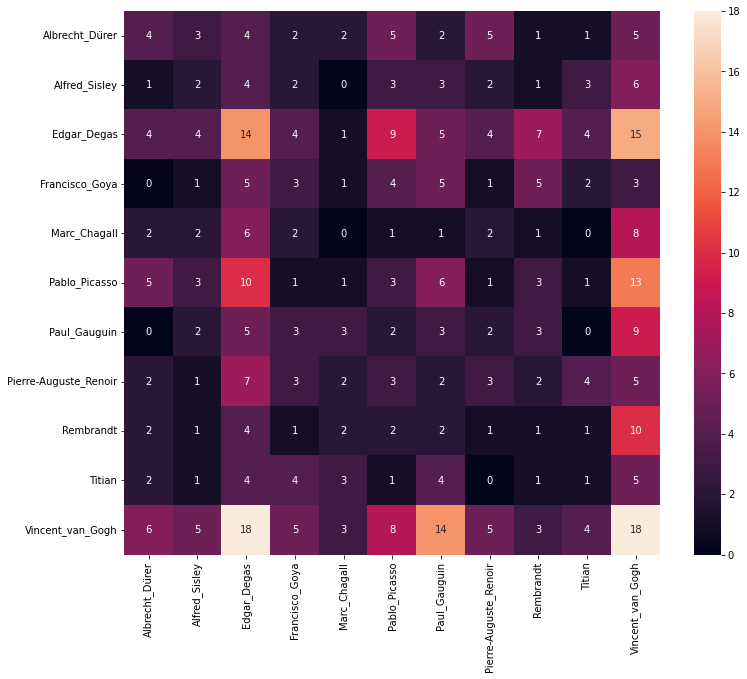

In [239]:
#confusion matrix
test_pred = m.predict(test_vgg)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test_vgg.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm,annot=True,fmt="d")

### Augmentation

In [353]:
augmentation = ImageDataGenerator( rescale=1/255,
                                    rotation_range = 20,
                                   #width_shift_range = 0.05,
                                   #height_shift_range = 0.05,
                                    horizontal_flip = True)
                                    #vertical_flip = True,
                                    #zoom_range=0.2)
                                    # brightness_range=(0.1, 0.9),
                                    # fill_mode='nearest')

In [354]:
train_vgg_aug=augmentation.flow_from_directory(
                                                  train_dir,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  classes = class_names,
                                                  seed = 123,
                                                  batch_size=32,
                                                  shuffle=True)

Found 3018 images belonging to 11 classes.


In [355]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(120, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.2)(x)
#x = Dense(50, activation='elu')(x) # number of layers and units are hyperparameters, as usual
predictions = Dense(11, activation='softmax')(x) # should match # of classes predicted


# define formal model object to train and compile it as usual
model5 = Model(inputs=base_model.input, outputs=predictions)
model5.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['Recall','Precision'])
es=EarlyStopping(monitor='val_recall',patience=4,mode='max')

In [ ]:
vgg_augmented= model5.fit(train_vgg_aug, epochs=20, validation_data=val_vgg,callbacks=es,class_weight=class_weights)

Epoch 1/20
95/95 [==============================] - 105s 1s/step - loss: 2.1077 - recall: 0.0729 - precision: 0.5116 - val_loss: 1.7274 - val_recall: 0.1350 - val_precision: 0.7682
Epoch 2/20
95/95 [==============================] - 103s 1s/step - loss: 1.4231 - recall: 0.2396 - precision: 0.6986 - val_loss: 1.3384 - val_recall: 0.3271 - val_precision: 0.7636
Epoch 3/20
95/95 [==============================] - 104s 1s/step - loss: 1.2602 - recall: 0.3310 - precision: 0.7297 - val_loss: 1.2380 - val_recall: 0.3050 - val_precision: 0.7572
Epoch 4/20
88/95 [==========================>...] - ETA: 6s - loss: 1.1422 - recall: 0.3865 - precision: 0.7600

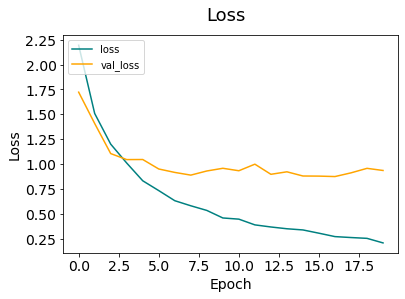

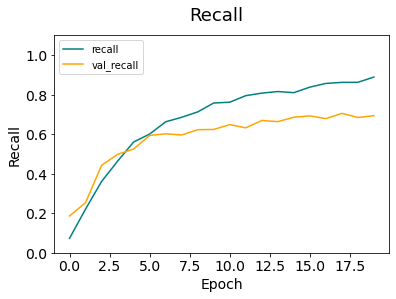

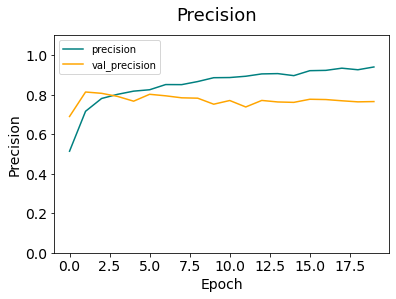

In [351]:
plot_performance(vgg_augmented)

14/14 [==============================] - 9s 606ms/step


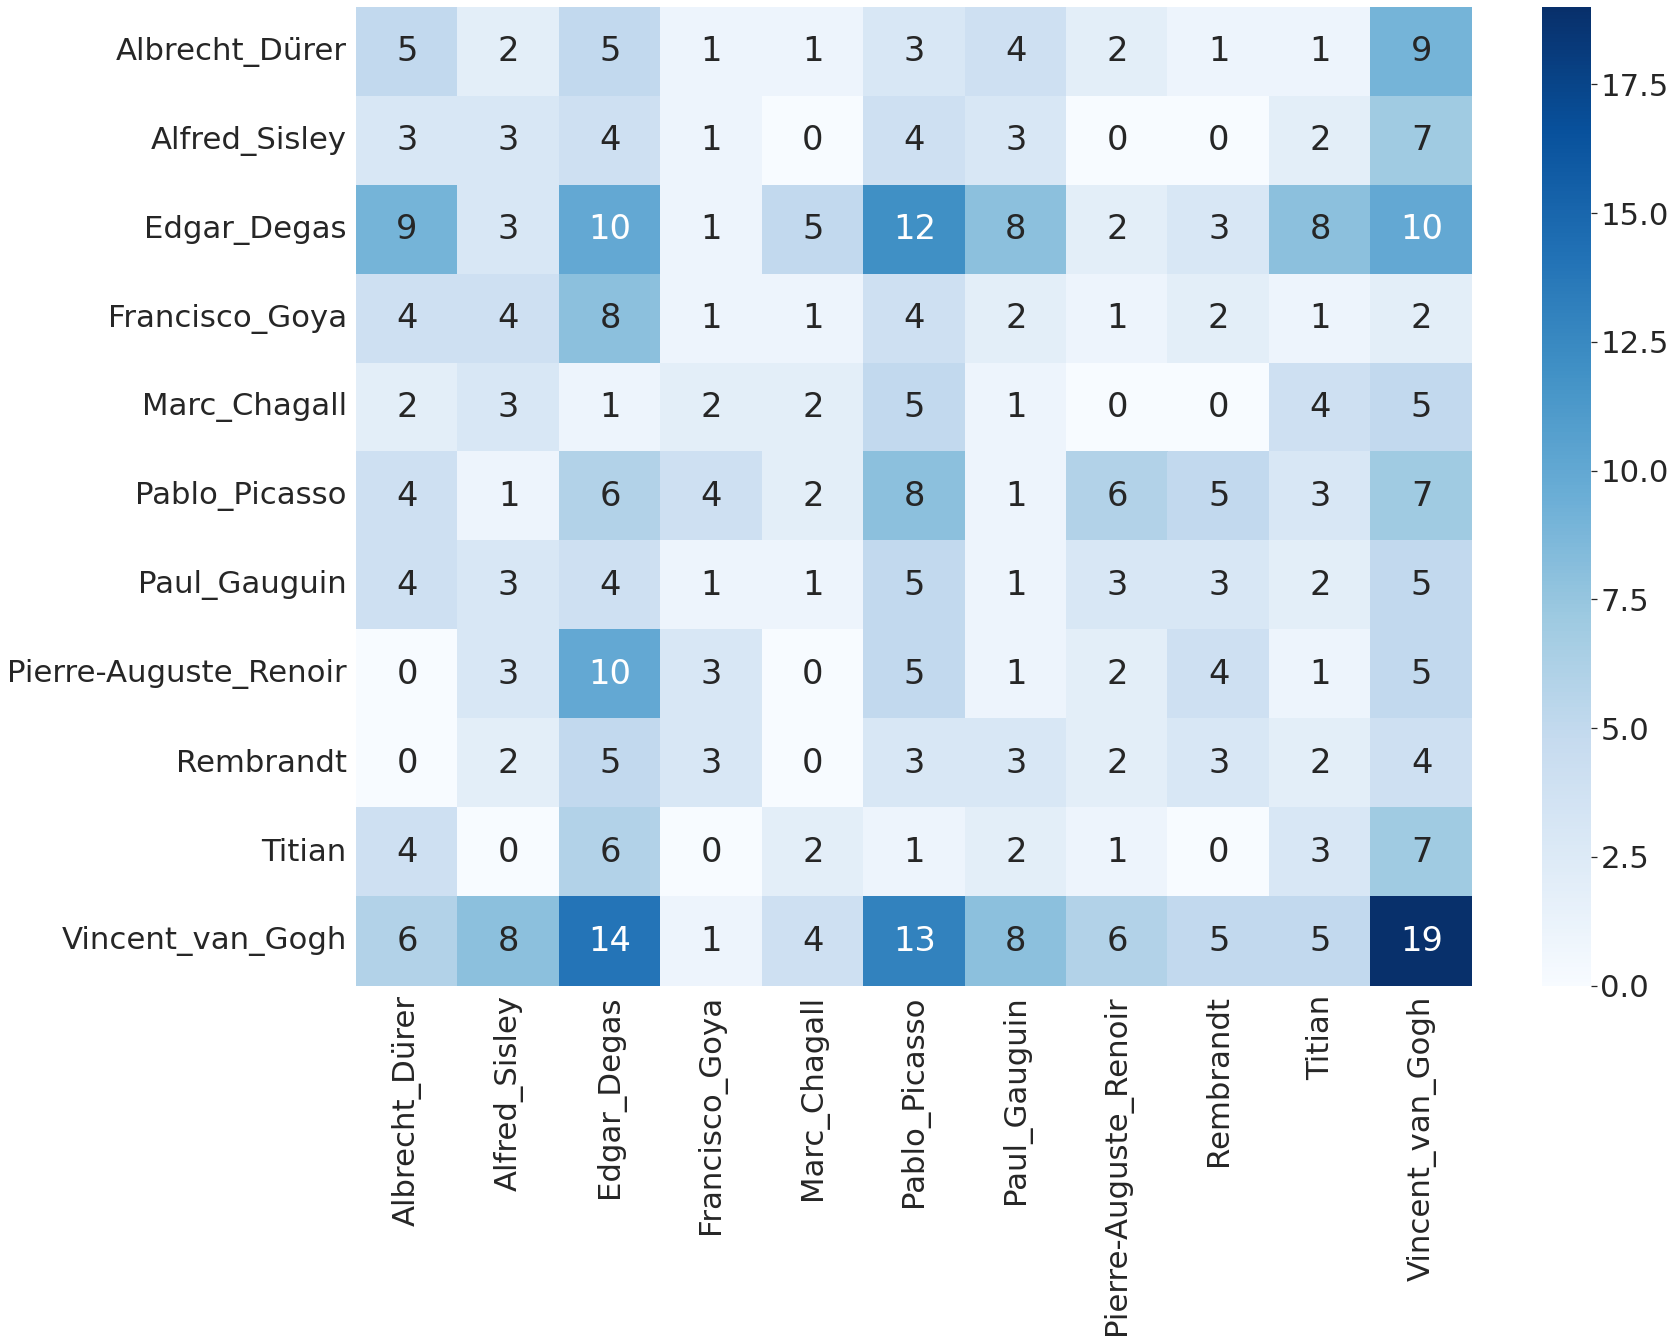

In [367]:
#confusion matrix
sns.set(font_scale=2.8)
test_pred = model5.predict(test_vgg)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
cm=confusion_matrix(test_vgg.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
plt.figure(figsize=(25,18))
sns.heatmap(df_cm,annot=True,fmt="d",cmap='Blues')

# Testing out other Models for Transfer Learning 

In [18]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

NameError: ignored

In [17]:
baseline_MNV2.save('riwa_model.pt')

NameError: ignored

In [16]:
m = keras.models.load_model('riwa_model.pt')

OSError: ignored

In [ ]:
m.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [ ]:
#confusion matrix
test_pred = .predict(test)
test_predicted_class = np.argmax(test_pred, axis=1)
from sklearn.metrics import *
confusion_matrix(test.classes, test_predicted_class)
df_cm = pd.DataFrame(cm,class_names,class_names)
     

In [ ]:
test_pred = m.predict(test)

14/14 [==============================] - 9s 568ms/step


In [ ]:
test_pred.shape

(442, 11)

In [ ]:
test_predicted_class = np.argmax(test_pred, axis=1)

In [ ]:
test_predicted_class[:10]

array([0, 0, 4, 4, 4, 4, 0, 0, 4, 0])

In [ ]:
test.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
test.classes.shape

(442,)

In [ ]:
test_predicted_class.s

(442,)

In [ ]:
from sklearn.metrics import *
confusion_matrix(test.classes, test_predicted_class)

array([[23,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 26,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4, 67,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  9, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 12, 13,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 10, 36,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 27,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 32,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 27,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 26,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 22, 67,  0,  0,  0,  0,  0]])

In [ ]:
x = m.clone_model()

AttributeError: ignored